# Imports

In [1]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as lines
from matplotlib.ticker import StrMethodFormatter

In [14]:
! ls ../dsc-phase-1-project-v2-4/im.db

../dsc-phase-1-project-v2-4/im.db


## Importing Data

In [9]:
budgets_df = pd.read_csv("../dsc-phase-1-project-v2-4/zippedData/tn.movie_budgets.csv.gz", parse_dates=["release_date"])

In [10]:
tmdb_df = pd.read_csv("../dsc-phase-1-project-v2-4/zippedData/tmdb.movies.csv.gz", parse_dates=["release_date"])

In [15]:
conn = sql.connect("../dsc-phase-1-project-v2-4/im.db")

In [17]:
imdb_df = pd.read_sql("SELECT * FROM movie_basics", conn)

# Cleaning the Data

### Genre Id to Genre

In [27]:
genre_id = {
    "Action" : 28,
    "Adventure" : 12,
    "Animation" : 16,
    "Comedy" : 35,
    "Crime" : 80,
    "Documentary" : 99,
    "Drama" : 18,
    "Family" : 10751,
    "Fantasy" : 14,
    "History" : 36,
    "Horror" : 27,
    "Music" : 10402,
    "Mystery" : 9648,
    "Romance" : 10749,
    "Science Fiction" : 878,
    "TV Movie" : 10770,
    "Thriller" : 53,
    "War" : 10752,
    "Western" : 37,
}

In [28]:
genre_id = {str(y):str(x) for x,y in genre_id.items()}

### Cleaning tmdb_df

In [19]:
tmdb_df_clean = tmdb_df.copy()

In [20]:
tmdb_df_clean["genre_ids"] = tmdb_df["genre_ids"].str.replace("]","").str.replace("[","").str.replace(",","").str.split(" ")
# We did this to convert the genre_ids from a string into a list

Now we only want movies from this data that have a vote count >= 1000

In [21]:
tmdb_df_clean = tmdb_df_clean.loc[tmdb_df_clean["vote_count"] >= 1000]

In [32]:
tmdb_df_clean_weighted_avg = tmdb_df_clean.explode(column="genre_ids")
# This was done to turn genre_ids from a list into strings

In [34]:
weighted_mean = lambda x: np.average(x, weights=tmdb_df_clean.loc[x.index, "vote_count"])

# Used to get a weighted vote average
weighted_avg = tmdb_df_clean.explode(column="genre_ids").groupby("genre_ids").agg(
    sum_vote_count=("vote_count", "sum"), 
    vote_weighted_mean=("vote_average", weighted_mean)).reset_index()

In [35]:
weighted_avg["genre_ids"] = weighted_avg["genre_ids"].map(genre_id)
# mapping to numbers to Genres

In [37]:
weighted_avg["count/vote_score"] = (weighted_avg["sum_vote_count"]/1000000) * weighted_avg["vote_weighted_mean"]
# Divided by 1000000 to keep numbers small

In [38]:
top = weighted_avg.sort_values("count/vote_score", ascending = False)

### Cleaning budgets_df

In [86]:
movie_budgets_df_clean = budgets_df.copy()

In [87]:
movie_budgets_df_clean['worldwide_gross'] = movie_budgets_df_clean['worldwide_gross'].str.replace("$", "").str.replace(",", "").astype("int64")

In [88]:
movie_budgets_df_clean['production_budget'] = movie_budgets_df_clean['production_budget'].str.replace("$", "").str.replace(",", "").astype("int64")

### Cleaning budgets_df for merge with tmdb_df_clean

In [40]:
m1 = budgets_df.copy()

In [41]:
m1["title"] = budgets_df["movie"]
# This was done to better merge with tmdb_df_clean

In [42]:
m1 = m1.drop(columns=["id", "domestic_gross", "worldwide_gross", "movie"])
# This was done to better merge with tmdb_df_clean

### Merging budgets_df and tmdb_df_clean

In [43]:
gm_df = tmdb_df_clean.merge(m1, how="inner")

In [44]:
gm_df = gm_df.drop(columns=["Unnamed: 0", "id", "original_language", "original_title", "popularity", "release_date", "title"])
# Dropping unused columns

In [45]:
gm_genre_df = gm_df.explode("genre_ids")
# This was done to turn genre_ids from a list into strings

In [46]:
gm_genre_df["genre_ids"] = gm_genre_df["genre_ids"].map(genre_id)
# mapping to numbers to Genres

In [47]:
gm_genre_df["production_budget"] = gm_genre_df["production_budget"].str.replace("$","").str.replace(",","")
#cleaning money string to turn into int

In [48]:
gm_genre_df["production_budget"] = gm_genre_df["production_budget"].astype(int)
# turned into int

In [50]:
gm_genre_avg = gm_genre_df.groupby("genre_ids").mean().reset_index()
#Grouped to find mean

In [70]:
top_gm_genre_avg = gm_genre_avg.sort_values("production_budget", ascending = False)

### Cleaning TMDB into top 6

In [57]:
mpy = tmdb_df_clean.explode(column = "genre_ids").groupby(['genre_ids']).agg(
    movies_produced = ('id', 'count')).reset_index()
# This was done to turn genre_ids from a list into strings

In [58]:
top_6 = mpy.sort_values('movies_produced', ascending = False)
#sorting values

In [59]:
top_6['genre_ids'] = top_6['genre_ids'].map(genre_id)
# mapping to numbers to Genres

In [60]:
top_6['percent'] = top_6['movies_produced']/sum(top_6['movies_produced'])
top_6['percent'] = top_6['percent'] * 100
#Turning count to percent

### Cleaning IMDB

In [62]:
imdb_df_clean = imdb_df.copy()

In [63]:
imdb_df_clean = imdb_df.dropna(subset = ['runtime_minutes', 'genres'])
#dropping nulls

In [64]:
imdb_df_clean["genres"] = imdb_df_clean["genres"].str.replace(",", " ").str.split(" ")
#Fixing Genre id

<ipython-input-64-c9c149e803d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_df_clean["genres"] = imdb_df_clean["genres"].str.replace(",", " ").str.split(" ")


In [65]:
imdb_df_clean = imdb_df_clean.explode(column = "genres").groupby("genres").mean().reset_index()
#Mapping Genre id from number to genres

In [66]:
top_6_avg_runtimes = imdb_df_clean.loc[(imdb_df_clean['genres'] == 'Drama') |
                 ( imdb_df_clean['genres'] == 'Action') |
                  (imdb_df_clean['genres'] == 'Comedy') |
                  (imdb_df_clean['genres'] == 'Thriller') |
                  (imdb_df_clean['genres'] == 'Adventure') |
                  (imdb_df_clean['genres'] == 'Sci-Fi')]
#List of top 6 genres

In [67]:
top_6_avg_runtimes = top_6_avg_runtimes.sort_values('runtime_minutes', ascending = False)
# ordering top 6

## Graph Lists

In [72]:
las = ["-$100 Million","$0", "$100 Million", "$200 Million", "$300 Million", "$400 Million"]

In [73]:
los = ["$0", "$20 Million", "$40 Million", "$60 Million", "$80 Million", "$100 Million", "$120 Million", "$140 Million"]

# Graphs

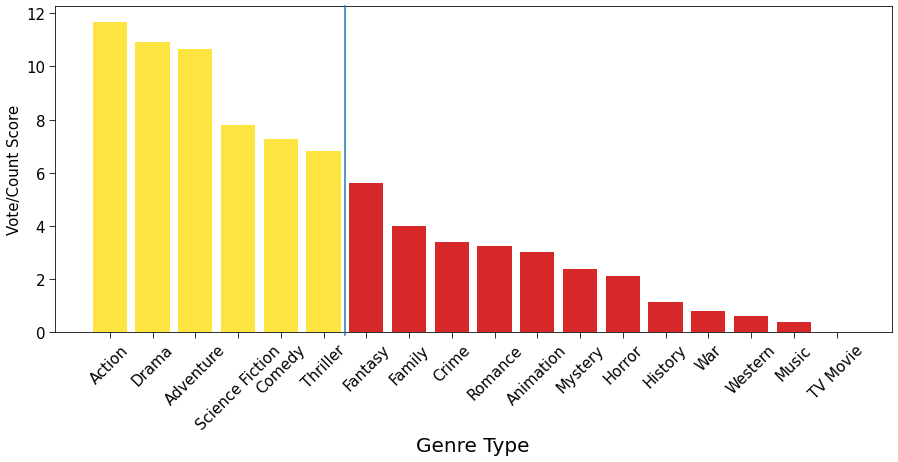

In [97]:
fig, ax = plt.subplots(figsize=(15,6))
palet =plt.get_cmap("Set1")
ax.bar(x=top["genre_ids"], height=top["count/vote_score"], color=["#fee440" if score > 6 else '#d62828' for score in top['count/vote_score']])

ax.set_xlabel("Genre Type", fontsize=20)
ax.set_ylabel("Vote/Count Score", fontsize=15)
# ax.set_title("Vote/Count Score Graph", fontsize=30)
fig.add_artist(lines.Line2D([.3935, .3935], [.12, .88]))
plt.xticks(rotation=45)
ax.tick_params(length=6, which="both", labelsize=15)
plt.savefig("Graphs/VoteCountScore.png", bbox_inches="tight")

<ipython-input-98-6842ef611272>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(los, minor=False)


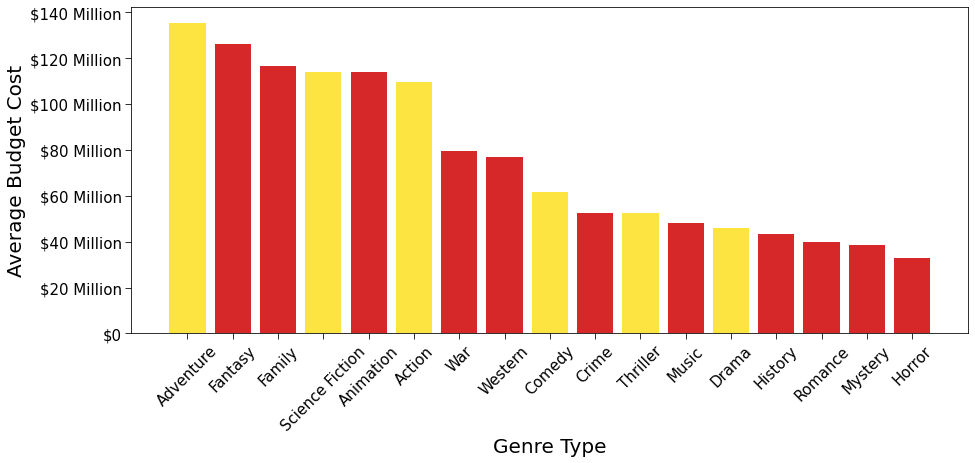

In [98]:
fig, ax = plt.subplots(figsize=(15,6))
palet =plt.get_cmap("Set1")
ax.bar(x=top_gm_genre_avg["genre_ids"], height=top_gm_genre_avg["production_budget"], color=["#fee440","#d62828","#d62828","#fee440","#d62828","#fee440","#d62828","#d62828","#fee440","#d62828","#fee440","#d62828","#fee440","#d62828","#d62828","#d62828","#d62828","#d62828"])

ax.set_xlabel("Genre Type", fontsize=20)
ax.set_ylabel("Average Budget Cost", fontsize=20)
# ax.set_title("Average Budget Cost per Genre", fontsize=30)
ax.set_yticklabels(los, minor=False)
plt.xticks(rotation=45)
ax.tick_params(length=6, which="both", labelsize=15)
plt.savefig("Graphs/Average_Budget_Cost_per_Genre.png", bbox_inches="tight")

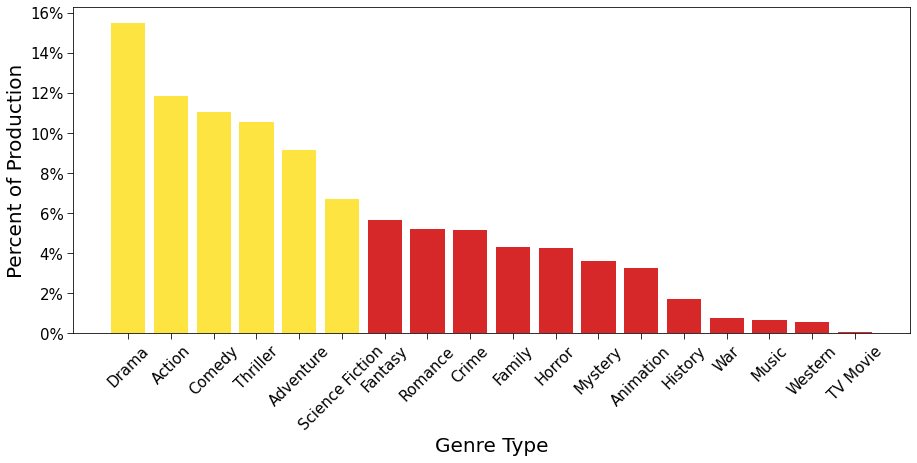

In [99]:
fig, ax = plt.subplots(figsize = (15, 6))
palette = plt.get_cmap('Set1')
ax.bar(top_6['genre_ids'], top_6['percent'], color = ["#fee440" if percent > 6 else '#D62828' for percent in top_6['percent']])
# ax.set_title("Top 6 Most Popular Genres to Produce", fontsize = 30)
ax.set_ylabel("Percent of Production", fontsize = 20)
ax.set_xlabel("Genre Type", fontsize = 20)
ax.tick_params(length = 6, which = ('both'))
plt.xticks(rotation = 45, fontsize=15)
plt.yticks(fontsize=15)
# ax.set_yticklabels(PV, minor = False)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))
plt.savefig("Graphs/Top_6_Most_Popular_Genres_to_Produce.png", bbox_inches="tight")
plt.show()

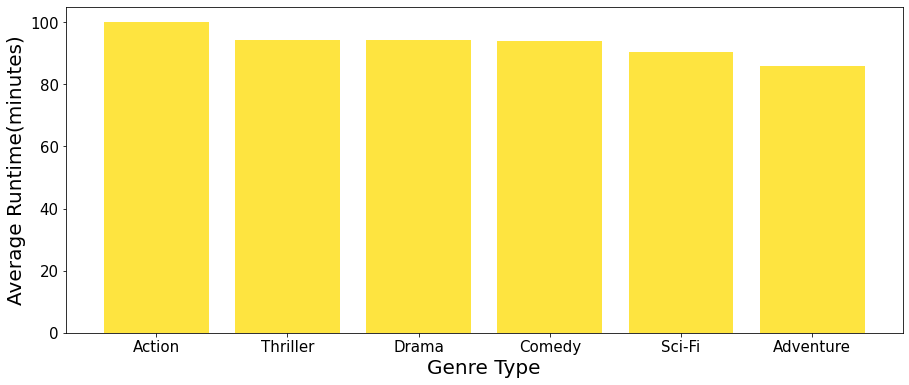

In [100]:
fig, ax = plt.subplots(figsize = (15, 6))
palette = plt.get_cmap('Set1')
ax.bar(top_6_avg_runtimes['genres'], top_6_avg_runtimes['runtime_minutes'], color = "#fee440")
# ax.set_title("Genres by Average Runtime(minutes)", fontsize=30)
ax.set_ylabel("Average Runtime(minutes)", fontsize=20)
ax.set_xlabel("Genre Type", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("Graphs/Genres_by_Average_Runtime(minutes).png", bbox_inches="tight")
plt.show()

<ipython-input-101-cea39583bc81>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(las, minor=False)


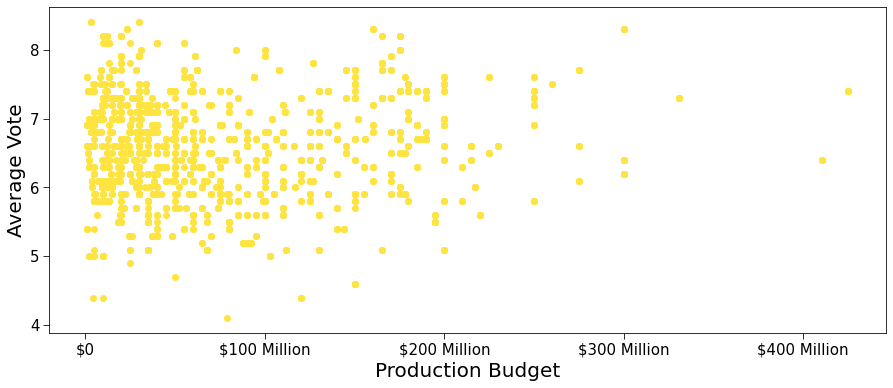

In [101]:
fig, ax = plt.subplots(figsize=(15,6))
palet =plt.get_cmap("Set1")
ax.scatter(y=gm_genre_df["vote_average"], x=gm_genre_df["production_budget"], color = "#fee440")

ax.set_xlabel("Production Budget", fontsize=20)
ax.set_ylabel("Average Vote", fontsize=20)
# ax.set_title("Budget Cost per Average Vote", fontsize=30)
ax.set_xticklabels(las, minor=False)
# ax.set_xticks(lis, minor=True)
# ax.set_xticklabels(lis, minor=True)
ax.tick_params(length=6, which="both", labelsize=15)
plt.savefig("Graphs/Budget_Cost_per_Average_Vote.png", bbox_inches="tight")

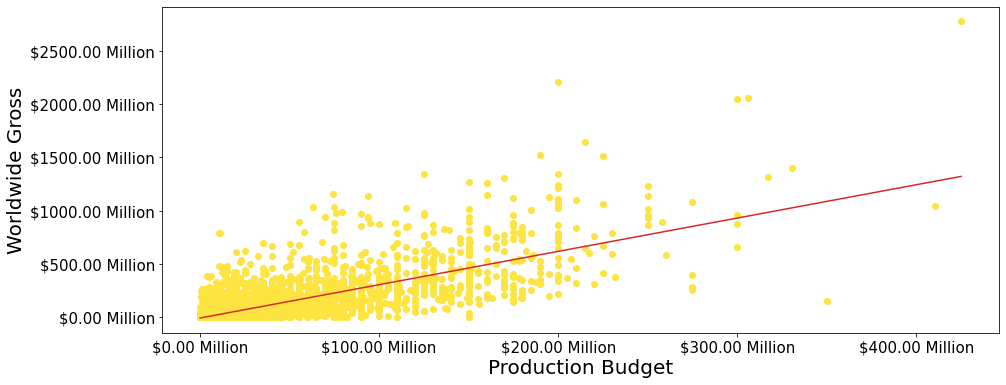

In [102]:
x = movie_budgets_df_clean['production_budget']/1000000
y = movie_budgets_df_clean['worldwide_gross']/1000000
palette = plt.get_cmap('Set1')
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(x, y, color = "#fee440")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color = '#D62828')
# ax.set_title("Correlation Between Budget and Gross", fontsize = 30)
ax.set_ylabel("Worldwide Gross", fontsize = 20)
ax.set_xlabel("Production Budget", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:.2f} Million'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:.2f} Million'))
plt.savefig("Graphs/Correlation_Between_Budget_and_Gross.png", bbox_inches="tight")
plt.show()